# Imports


In [1]:
import os, time, random
import cv2
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

from tqdm import tqdm
import torchvision.models as models
import torchvision.models.segmentation as segmodels

# PATHS

In [2]:
IMG_DIR  = "/kaggle/input/isic201882/ISIC2018/images_aug_20000"
MASK_DIR = "/kaggle/input/isic201882/ISIC2018/masks_aug_20000"
IMG_EXT  = ".jpg"
MASK_EXT = ".png"


SEED   = 42
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", DEVICE)

EPOCHS = 3  
LR_LIST    = [1e-4, 3e-5, 1e-5]     
BATCH_LIST = [4, 8, 16]             

TRAIN_RATIO = 0.70
VAL_RATIO   = 0.15
TEST_RATIO  = 0.15


def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)


Device: cuda


# TRANSFORMS

In [3]:
train_tfms = A.Compose([
    A.Resize(256, 256),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.10, rotate_limit=20, p=0.7),
    A.Normalize(),
    ToTensorV2()
])

val_tfms = A.Compose([
    A.Resize(256, 256),
    A.Normalize(),
    ToTensorV2()
])

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


# DATASET

In [4]:
class ISICSegDataset(Dataset):
    def __init__(self, img_dir, mask_dir, ids, transform=None):
        self.img_dir = img_dir
        self.mask_dir = mask_dir
        self.ids = ids
        self.transform = transform

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        img_id = self.ids[idx]
        img_path  = os.path.join(self.img_dir, img_id + IMG_EXT)
        mask_path = os.path.join(self.mask_dir, img_id + MASK_EXT)

        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        if img is None:
            raise FileNotFoundError(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if mask is None:
            raise FileNotFoundError(mask_path)
        mask = (mask > 0).astype(np.float32)

        if self.transform:
            out = self.transform(image=img, mask=mask)
            img = out["image"]
            mask = out["mask"]

        return img, mask.unsqueeze(0)  



In [5]:
# Collect IDs from image folder
all_ids = sorted([f.replace(IMG_EXT, "") for f in os.listdir(IMG_DIR) if f.endswith(IMG_EXT)])
print("Total IDs:", len(all_ids))
print("Example IDs:", all_ids[:5])

Total IDs: 20000
Example IDs: ['ISIC_0000000', 'ISIC_0000000_aug_005082', 'ISIC_0000000_aug_010963', 'ISIC_0000001', 'ISIC_0000001_aug_002315']


# 3-WAY SPLIT

In [6]:
def split_ids_three_way(ids, train_ratio=0.7, val_ratio=0.15, test_ratio=0.15, seed=42):
    assert abs(train_ratio + val_ratio + test_ratio - 1.0) < 1e-6
    rng = np.random.RandomState(seed)
    ids = np.array(ids)
    rng.shuffle(ids)

    n = len(ids)
    n_train = int(n * train_ratio)
    n_val   = int(n * val_ratio)
    train_ids = ids[:n_train].tolist()
    val_ids   = ids[n_train:n_train+n_val].tolist()
    test_ids  = ids[n_train+n_val:].tolist()
    return train_ids, val_ids, test_ids

train_ids, val_ids, test_ids = split_ids_three_way(all_ids, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, SEED)
print(f"Split sizes: train={len(train_ids)}, val={len(val_ids)}, test={len(test_ids)}")


Split sizes: train=14000, val=3000, test=3000


# VISUALIZATION: samples

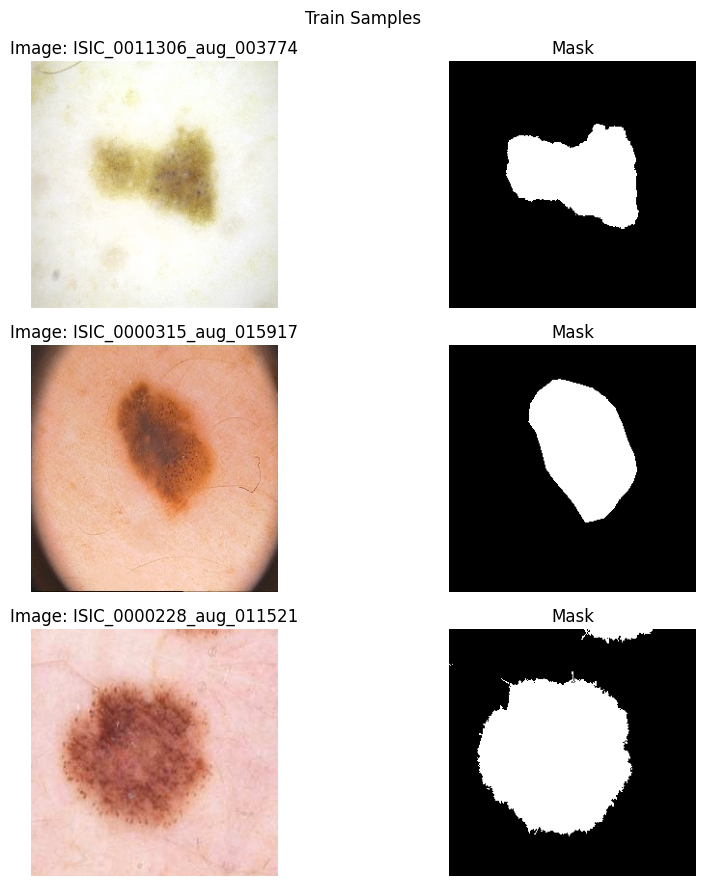

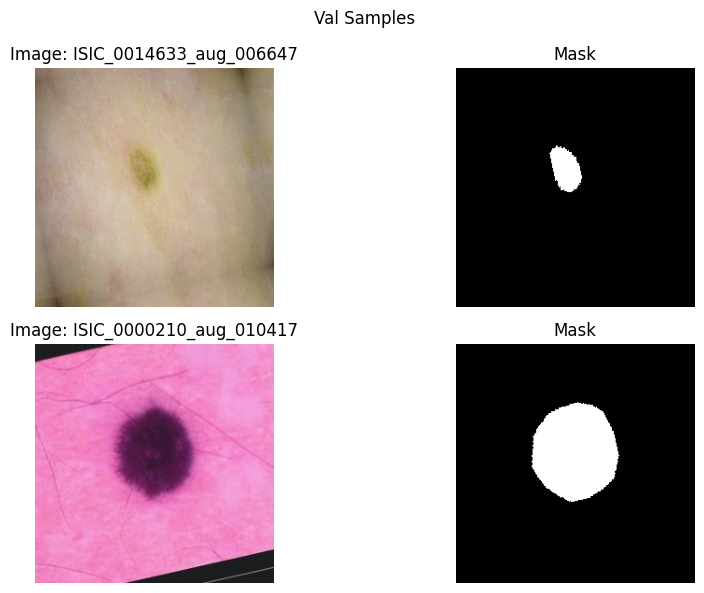

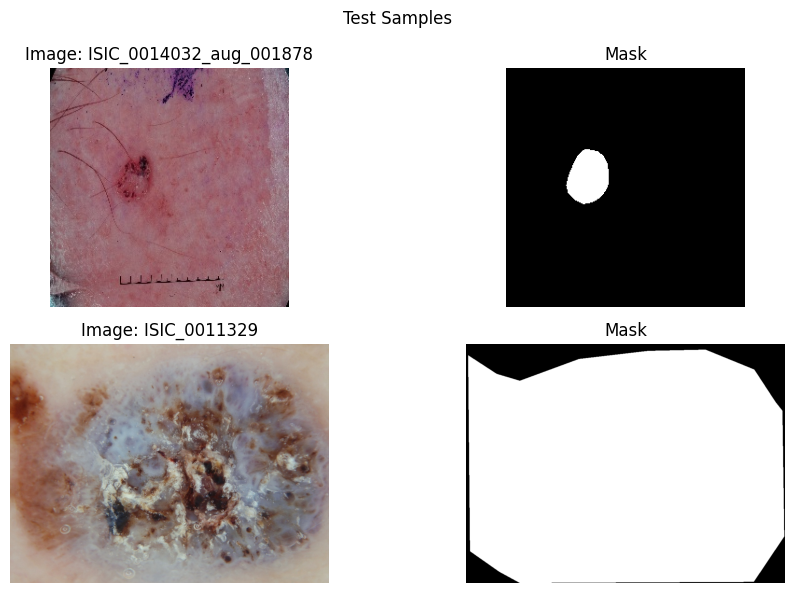

In [7]:
def show_samples(ids, n=3, title="Samples"):
    pick = np.random.choice(ids, n, replace=False)
    plt.figure(figsize=(10, 3*n))
    for i, img_id in enumerate(pick, 1):
        img = cv2.imread(os.path.join(IMG_DIR, img_id + IMG_EXT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(os.path.join(MASK_DIR, img_id + MASK_EXT), 0)

        plt.subplot(n, 2, 2*i-1)
        plt.imshow(img); plt.axis("off"); plt.title(f"Image: {img_id}")

        plt.subplot(n, 2, 2*i)
        plt.imshow(mask, cmap="gray"); plt.axis("off"); plt.title("Mask")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_samples(train_ids, n=3, title="Train Samples")
show_samples(val_ids, n=2, title="Val Samples")
show_samples(test_ids, n=2, title="Test Samples")


# METRICS + LOSSES

In [8]:
bce_logits = nn.BCEWithLogitsLoss()

@torch.no_grad()
def dice_from_logits(logits, target, eps=1e-6):
    prob = torch.sigmoid(logits)
    pred = (prob > 0.5).float()
    inter = (pred * target).sum(dim=(2,3))
    union = pred.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return dice.mean().item()

def soft_dice_loss_from_logits(logits, target, eps=1e-6):
    prob = torch.sigmoid(logits)
    inter = (prob * target).sum(dim=(2,3))
    union = prob.sum(dim=(2,3)) + target.sum(dim=(2,3))
    dice = (2*inter + eps) / (union + eps)
    return 1 - dice.mean()


# MODELS

In [9]:
class VGG16_UNet(nn.Module):
    def __init__(self):
        super().__init__()
        vgg = models.vgg16(weights=models.VGG16_Weights.IMAGENET1K_V1).features

        self.enc1 = vgg[:5]
        self.enc2 = vgg[5:10]
        self.enc3 = vgg[10:17]
        self.enc4 = vgg[17:24]
        self.enc5 = vgg[24:31]

        self.up = nn.Upsample(scale_factor=2, mode="nearest")

        def conv(i, o):
            return nn.Sequential(
                nn.Conv2d(i, o, 3, padding=1), nn.ReLU(inplace=True),
                nn.Conv2d(o, o, 3, padding=1), nn.ReLU(inplace=True)
            )

        self.d5 = conv(512+512, 512)
        self.d4 = conv(512+256, 256)
        self.d3 = conv(256+128, 128)
        self.d2 = conv(128+64,  64)
        self.d1 = conv(64, 64)

        self.final = nn.Conv2d(64, 1, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(e1)
        e3 = self.enc3(e2)
        e4 = self.enc4(e3)
        e5 = self.enc5(e4)

        d5 = self.d5(torch.cat([self.up(e5), e4], dim=1))
        d4 = self.d4(torch.cat([self.up(d5), e3], dim=1))
        d3 = self.d3(torch.cat([self.up(d4), e2], dim=1))
        d2 = self.d2(torch.cat([self.up(d3), e1], dim=1))

        d1 = self.d1(self.up(d2))
        return self.final(d1)


In [10]:
def DeepLabV3_R50():
    m = segmodels.deeplabv3_resnet50(weights="DEFAULT")
    m.classifier[4] = nn.Conv2d(256, 1, kernel_size=1)
    return m


def model_forward(model, x, arch_name):
    if arch_name == "DeepLabV3_R50":
        return model(x)["out"]
    return model(x)

# TRAIN / EVAL

In [11]:
def train_one_model(model, arch_name, train_loader, val_loader, epochs, lr):
    model.to(DEVICE)
    opt = torch.optim.Adam(model.parameters(), lr=lr)

    hist = {"train_loss": [], "val_loss": [], "train_dice": [], "val_dice": []}

    for ep in range(1, epochs + 1):
        
        model.train()
        tr_loss_sum, tr_dice_sum = 0.0, 0.0

        loop = tqdm(train_loader, desc=f"{arch_name} | Ep {ep}/{epochs} [TRAIN]", leave=False)
        for xb, yb in loop:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)

            logits = model_forward(model, xb, arch_name)
            loss = 0.5*bce_logits(logits, yb) + 0.5*soft_dice_loss_from_logits(logits, yb)

            opt.zero_grad()
            loss.backward()
            opt.step()

            tr_loss_sum += loss.item()
            tr_dice_sum += dice_from_logits(logits, yb)

            loop.set_postfix(loss=f"{loss.item():.4f}")

        
        model.eval()
        va_loss_sum, va_dice_sum = 0.0, 0.0
        n_batches = 0

        with torch.no_grad():
            loop2 = tqdm(val_loader, desc=f"{arch_name} | Ep {ep}/{epochs} [VAL]", leave=False)
            for xb, yb in loop2:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model_forward(model, xb, arch_name)

                vloss = 0.5*bce_logits(logits, yb) + 0.5*soft_dice_loss_from_logits(logits, yb)
                vdice = dice_from_logits(logits, yb)

                va_loss_sum += vloss.item()
                va_dice_sum += vdice
                n_batches += 1
                loop2.set_postfix(vloss=f"{vloss.item():.4f}")

        tr_loss = tr_loss_sum / max(1, len(train_loader))
        va_loss = va_loss_sum / max(1, n_batches)
        tr_dice = tr_dice_sum / max(1, len(train_loader))
        va_dice = va_dice_sum / max(1, n_batches)

        hist["train_loss"].append(tr_loss)
        hist["val_loss"].append(va_loss)
        hist["train_dice"].append(tr_dice)
        hist["val_dice"].append(va_dice)

        print(f"{arch_name} | Epoch {ep}/{epochs} | TrainDice={tr_dice:.4f} | ValDice={va_dice:.4f}")

    return hist, model


In [12]:
@torch.no_grad()
def evaluate_model(model, arch_name, loader, title="EVAL"):
    model.eval()
    loss_sum, dice_sum = 0.0, 0.0
    n_batches = 0

    for xb, yb in tqdm(loader, desc=f"{arch_name} | {title}", leave=False):
        xb, yb = xb.to(DEVICE), yb.to(DEVICE)
        logits = model_forward(model, xb, arch_name)
        loss = 0.5*bce_logits(logits, yb) + 0.5*soft_dice_loss_from_logits(logits, yb)
        dice = dice_from_logits(logits, yb)
        loss_sum += loss.item()
        dice_sum += dice
        n_batches += 1

    return (loss_sum / max(1, n_batches)), (dice_sum / max(1, n_batches))

# SAVE / LOAD

In [13]:
def save_model_state(model, arch, lr, batch, val_dice):
    os.makedirs("saved_models", exist_ok=True)
    path = f"saved_models/{arch}_LR{lr}_B{batch}_val{val_dice:.4f}.pth"
    torch.save(model.state_dict(), path)
    print("✅ Saved:", path)
    return path

def load_model_state(model, path):
    sd = torch.load(path, map_location=DEVICE)
    model.load_state_dict(sd)
    return model

# LEARNING CURVE PLOT

In [14]:
def plot_learning_curve(hist, title="Learning Curve"):
    epochs = list(range(1, len(hist["train_dice"]) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, hist["train_dice"], marker="o", label="Train Dice")
    plt.plot(epochs, hist["val_dice"], marker="s", label="Val Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

# DATALOADERS (fixed split)

In [15]:
train_ds = ISICSegDataset(IMG_DIR, MASK_DIR, train_ids, transform=train_tfms)
val_ds   = ISICSegDataset(IMG_DIR, MASK_DIR, val_ids, transform=val_tfms)
test_ds  = ISICSegDataset(IMG_DIR, MASK_DIR, test_ids, transform=val_tfms)


# TUNING for 2 MODELS

In [ ]:
def tune_model(arch_name):
    best_val = -1.0
    best_cfg = None
    best_path = None
    best_hist = None

    for lr in LR_LIST:
        for batch in BATCH_LIST:
            print("\n" + "="*80)
            print(f"TUNING {arch_name}: LR={lr} | BATCH={batch} | EPOCHS={EPOCHS}")
            print("="*80)

            set_seed(SEED)

            tr_ld = DataLoader(train_ds, batch_size=batch, shuffle=True,  num_workers=0, drop_last=True)
            va_ld = DataLoader(val_ds,   batch_size=batch, shuffle=False, num_workers=0)

            # build model
            if arch_name == "VGG16_UNet":
                model = VGG16_UNet()
            elif arch_name == "DeepLabV3_R50":
                model = DeepLabV3_R50()
            else:
                raise ValueError("Unknown arch")

            hist, trained = train_one_model(model, arch_name, tr_ld, va_ld, epochs=EPOCHS, lr=lr)

            val_dice = hist["val_dice"][-1]
            print(f"✅ FINAL ValDice = {val_dice:.4f}")

            if val_dice > best_val:
                best_val = val_dice
                best_cfg = (lr, batch)
                best_hist = hist
                best_path = save_model_state(trained, arch_name, lr, batch, val_dice)

    return {
        "best_val": best_val,
        "best_cfg": best_cfg,
        "best_path": best_path,
        "best_hist": best_hist
    }

results = {}
for arch in ["VGG16_UNet", "DeepLabV3_R50"]:
    results[arch] = tune_model(arch)

print("\n" + "#"*80)
print("BEST SETTINGS SUMMARY")
print("#"*80)
for arch in results:
    print(f"{arch}: BestVal={results[arch]['best_val']:.4f} | BestCfg={results[arch]['best_cfg']} | Path={results[arch]['best_path']}")




TUNING VGG16_UNet: LR=0.0001 | BATCH=4 | EPOCHS=3
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 215MB/s]  


VGG16_UNet | Epoch 1/3 | TrainDice=0.8409 | ValDice=0.8684


VGG16_UNet | Epoch 2/3 | TrainDice=0.8725 | ValDice=0.8693


VGG16_UNet | Epoch 3/3 | TrainDice=0.8813 | ValDice=0.8841
✅ FINAL ValDice = 0.8841
✅ Saved: saved_models/VGG16_UNet_LR0.0001_B4_val0.8841.pth

TUNING VGG16_UNet: LR=0.0001 | BATCH=8 | EPOCHS=3


VGG16_UNet | Epoch 1/3 | TrainDice=0.8383 | ValDice=0.8708


VGG16_UNet | Epoch 2/3 | TrainDice=0.8759 | ValDice=0.8780


VGG16_UNet | Epoch 3/3 | TrainDice=0.8847 | ValDice=0.8866
✅ FINAL ValDice = 0.8866
✅ Saved: saved_models/VGG16_UNet_LR0.0001_B8_val0.8866.pth

TUNING VGG16_UNet: LR=0.0001 | BATCH=16 | EPOCHS=3


VGG16_UNet | Epoch 1/3 | TrainDice=0.8285 | ValDice=0.8639


VGG16_UNet | Epoch 2/3 | TrainDice=0.8773 | ValDice=0.8830


VGG16_UNet | Epoch 3/3 | TrainDice=0.8875 | ValDice=0.8846
✅ FINAL ValDice = 0.8846

TUNING VGG16_UNet: LR=3e-05 | BATCH=4 | EPOCHS=3


VGG16_UNet | Epoch 1/3 | TrainDice=0.8408 | ValDice=0.8738


VGG16_UNet | Epoch 2/3 | TrainDice=0.8826 | ValDice=0.8842


VGG16_UNet | Epoch 3/3 | TrainDice=0.8903 | ValDice=0.8944
✅ FINAL ValDice = 0.8944
✅ Saved: saved_models/VGG16_UNet_LR3e-05_B4_val0.8944.pth

TUNING VGG16_UNet: LR=3e-05 | BATCH=8 | EPOCHS=3


VGG16_UNet | Epoch 1/3 | TrainDice=0.8256 | ValDice=0.8674


VGG16_UNet | Epoch 2/3 | TrainDice=0.8806 | ValDice=0.8820


VGG16_UNet | Epoch 3/3 | TrainDice=0.8906 | ValDice=0.8948
✅ FINAL ValDice = 0.8948
✅ Saved: saved_models/VGG16_UNet_LR3e-05_B8_val0.8948.pth

TUNING VGG16_UNet: LR=3e-05 | BATCH=16 | EPOCHS=3


VGG16_UNet | Epoch 1/3 | TrainDice=0.8060 | ValDice=0.8673


VGG16_UNet | Epoch 2/3 | TrainDice=0.8774 | ValDice=0.8792


VGG16_UNet | Epoch 3/3 | TrainDice=0.8888 | ValDice=0.8901
✅ FINAL ValDice = 0.8901

TUNING VGG16_UNet: LR=1e-05 | BATCH=4 | EPOCHS=3


VGG16_UNet | Epoch 1/3 | TrainDice=0.8186 | ValDice=0.8657


VGG16_UNet | Epoch 2/3 | TrainDice=0.8767 | ValDice=0.8659


VGG16_UNet | Epoch 3/3 | TrainDice=0.8872 | ValDice=0.8896
✅ FINAL ValDice = 0.8896

TUNING VGG16_UNet: LR=1e-05 | BATCH=8 | EPOCHS=3


VGG16_UNet | Epoch 1/3 | TrainDice=0.7949 | ValDice=0.8524


VGG16_UNet | Epoch 2/3 | TrainDice=0.8700 | ValDice=0.8661


VGG16_UNet | Epoch 3/3 | TrainDice=0.8834 | ValDice=0.8840
✅ FINAL ValDice = 0.8840

TUNING VGG16_UNet: LR=1e-05 | BATCH=16 | EPOCHS=3


VGG16_UNet | Epoch 1/3 | TrainDice=0.7561 | ValDice=0.8445


VGG16_UNet | Epoch 2/3 | TrainDice=0.8608 | ValDice=0.8562


VGG16_UNet | Epoch 3/3 | TrainDice=0.8767 | ValDice=0.8798
✅ FINAL ValDice = 0.8798

TUNING DeepLabV3_R50: LR=0.0001 | BATCH=4 | EPOCHS=3
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 219MB/s] 


DeepLabV3_R50 | Epoch 1/3 | TrainDice=0.8525 | ValDice=0.8667


DeepLabV3_R50 | Epoch 2/3 | TrainDice=0.8803 | ValDice=0.8736


DeepLabV3_R50 | Epoch 3/3 | TrainDice=0.8858 | ValDice=0.8822
✅ FINAL ValDice = 0.8822
✅ Saved: saved_models/DeepLabV3_R50_LR0.0001_B4_val0.8822.pth

TUNING DeepLabV3_R50: LR=0.0001 | BATCH=8 | EPOCHS=3


DeepLabV3_R50 | Epoch 1/3 | TrainDice=0.8567 | ValDice=0.8773


DeepLabV3_R50 | Epoch 2/3 | TrainDice=0.8849 | ValDice=0.8858


DeepLabV3_R50 | Epoch 3/3 | TrainDice=0.8901 | ValDice=0.8802
✅ FINAL ValDice = 0.8802

TUNING DeepLabV3_R50: LR=0.0001 | BATCH=16 | EPOCHS=3


DeepLabV3_R50 | Ep 1/3 [TRAIN]:  28%|██▊       | 245/875 [10:32<26:36,  2.53s/it, loss=0.3191]

In [16]:
os.makedirs("saved_models", exist_ok=True)

model = VGG16_UNet()
hist_vgg, model = train_one_model(
    model,
    "VGG16_UNet",
    DataLoader(train_ds, batch_size=8, shuffle=True, drop_last=True),
    DataLoader(val_ds, batch_size=8, shuffle=False),
    epochs=EPOCHS,
    lr=3e-05
)
torch.save(model.state_dict(), "saved_models/VGG16_UNet_BEST.pth")

model = DeepLabV3_R50()
hist_dl, model = train_one_model(
    model,
    "DeepLabV3_R50",
    DataLoader(train_ds, batch_size=4, shuffle=True, drop_last=True),
    DataLoader(val_ds, batch_size=4, shuffle=False),
    epochs=EPOCHS,
    lr=1e-04
)
torch.save(model.state_dict(), "saved_models/DeepLabV3_R50_BEST.pth")


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 232MB/s]  


VGG16_UNet | Epoch 1/3 | TrainDice=0.8258 | ValDice=0.8708


VGG16_UNet | Epoch 2/3 | TrainDice=0.8806 | ValDice=0.8704


VGG16_UNet | Epoch 3/3 | TrainDice=0.8907 | ValDice=0.8960
Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth


100%|██████████| 161M/161M [00:00<00:00, 182MB/s]  


DeepLabV3_R50 | Epoch 1/3 | TrainDice=0.8504 | ValDice=0.8736


DeepLabV3_R50 | Epoch 2/3 | TrainDice=0.8791 | ValDice=0.8760


DeepLabV3_R50 | Epoch 3/3 | TrainDice=0.8864 | ValDice=0.8860


# LEARNING CURVES for BEST RUN

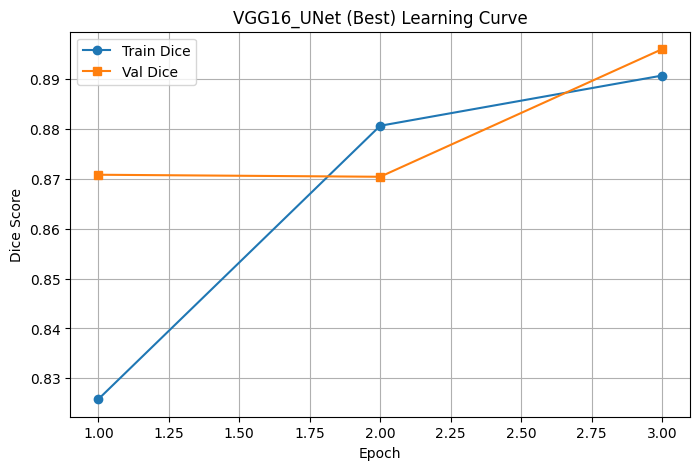

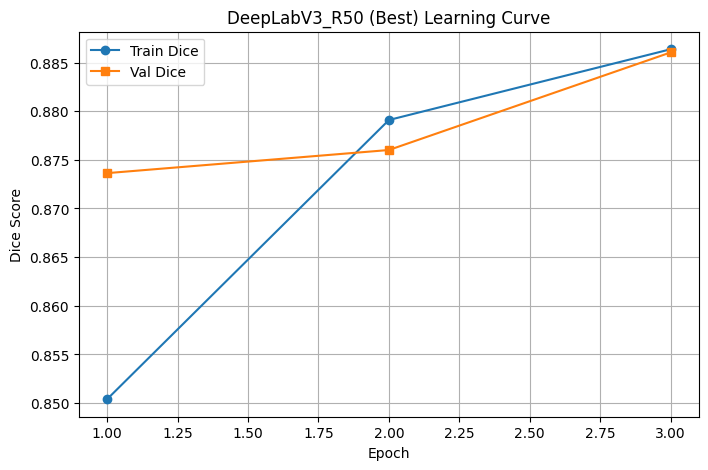

In [17]:

def plot_learning_curve(hist, title="Learning Curve"):
    epochs = list(range(1, len(hist["train_dice"]) + 1))

    plt.figure(figsize=(8, 5))
    plt.plot(epochs, hist["train_dice"], marker="o", label="Train Dice")
    plt.plot(epochs, hist["val_dice"], marker="s", label="Val Dice")
    plt.xlabel("Epoch")
    plt.ylabel("Dice Score")
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()

plot_learning_curve(hist_vgg, title="VGG16_UNet (Best) Learning Curve")
plot_learning_curve(hist_dl,  title="DeepLabV3_R50 (Best) Learning Curve")


# TEST EVALUATION (best saved model)

In [20]:
import os, glob, time
import torch
from torch.utils.data import DataLoader

SAVE_DIR = "/kaggle/working/saved_models"
os.makedirs(SAVE_DIR, exist_ok=True)

def save_best_state_dict(model, path):
    torch.save(model.state_dict(), path)
    # verify it exists and has size > 0
    assert os.path.isfile(path), f"Save failed: file not found at {path}"
    assert os.path.getsize(path) > 0, f"Save failed: file size is 0 at {path}"
    print("✅ Saved OK:", path, "| size(MB):", round(os.path.getsize(path)/1024/1024, 2))


In [22]:

arch = "DeepLabV3_R50"
best_lr = 1e-4
best_batch = 4

train_loader = DataLoader(train_ds, batch_size=best_batch, shuffle=True, drop_last=True, num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=best_batch, shuffle=False, num_workers=0)

model = DeepLabV3_R50().to(DEVICE)

print(f"\nTraining {arch} only | LR={best_lr} | BATCH={best_batch} | EPOCHS={EPOCHS}")
hist_dl, model = train_one_model(model, arch, train_loader, val_loader, epochs=EPOCHS, lr=best_lr)


val_dice = hist_dl["val_dice"][-1]
save_path = os.path.join(SAVE_DIR, f"{arch}_BEST_val{val_dice:.4f}.pth")
save_best_state_dict(model, save_path)

print("\nFiles in saved_models now:")
for f in sorted(glob.glob(SAVE_DIR + "/*.pth")):
    print(" -", f)


Training DeepLabV3_R50 only | LR=0.0001 | BATCH=4 | EPOCHS=3


DeepLabV3_R50 | Epoch 1/3 | TrainDice=0.8523 | ValDice=0.8669


DeepLabV3_R50 | Epoch 2/3 | TrainDice=0.8784 | ValDice=0.8880


DeepLabV3_R50 | Epoch 3/3 | TrainDice=0.8855 | ValDice=0.8879
✅ Saved OK: /kaggle/working/saved_models/DeepLabV3_R50_BEST_val0.8879.pth | size(MB): 160.56

Files in saved_models now:
 - /kaggle/working/saved_models/DeepLabV3_R50_BEST.pth
 - /kaggle/working/saved_models/DeepLabV3_R50_BEST_val0.8879.pth
 - /kaggle/working/saved_models/VGG16_UNet_BEST.pth


In [23]:


test_ld = DataLoader(test_ds, batch_size=8, shuffle=False, num_workers=0)

print("\n" + "#"*80)
print("TEST EVALUATION (Using Best Saved Models)")
print("#"*80)

vgg = VGG16_UNet()
vgg = load_model_state(vgg, "/kaggle/working/saved_models/VGG16_UNet_BEST.pth").to(DEVICE)
test_loss_vgg, test_dice_vgg = evaluate_model(vgg, "VGG16_UNet", test_ld, title="TEST")
print(f"VGG16_UNet | TEST Loss={test_loss_vgg:.4f} | TEST Dice={test_dice_vgg:.4f}")

dl = DeepLabV3_R50()
dl = load_model_state(dl, "/kaggle/working/saved_models/DeepLabV3_R50_BEST.pth").to(DEVICE)
test_loss_dl, test_dice_dl = evaluate_model(dl, "DeepLabV3_R50", test_ld, title="TEST")
print(f"DeepLabV3_R50 | TEST Loss={test_loss_dl:.4f} | TEST Dice={test_dice_dl:.4f}")



################################################################################
TEST EVALUATION (Using Best Saved Models)
################################################################################


VGG16_UNet | TEST Loss=0.1148 | TEST Dice=0.8949


DeepLabV3_R50 | TEST Loss=0.1262 | TEST Dice=0.8834


# VISUALIZE PREDICTIONS on TEST


Showing prediction visualizations on TEST set...


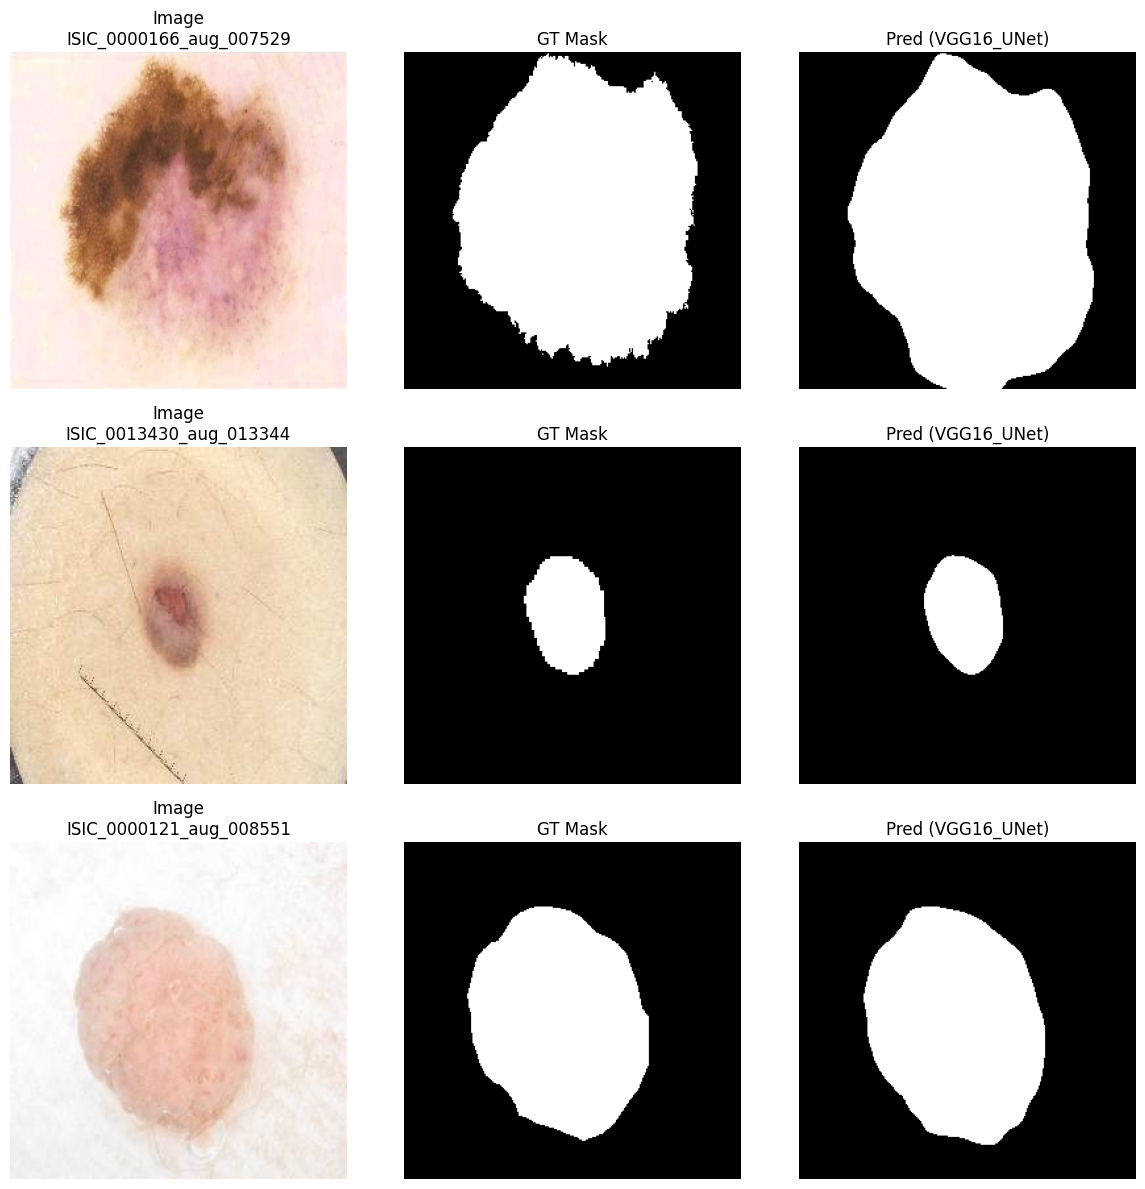

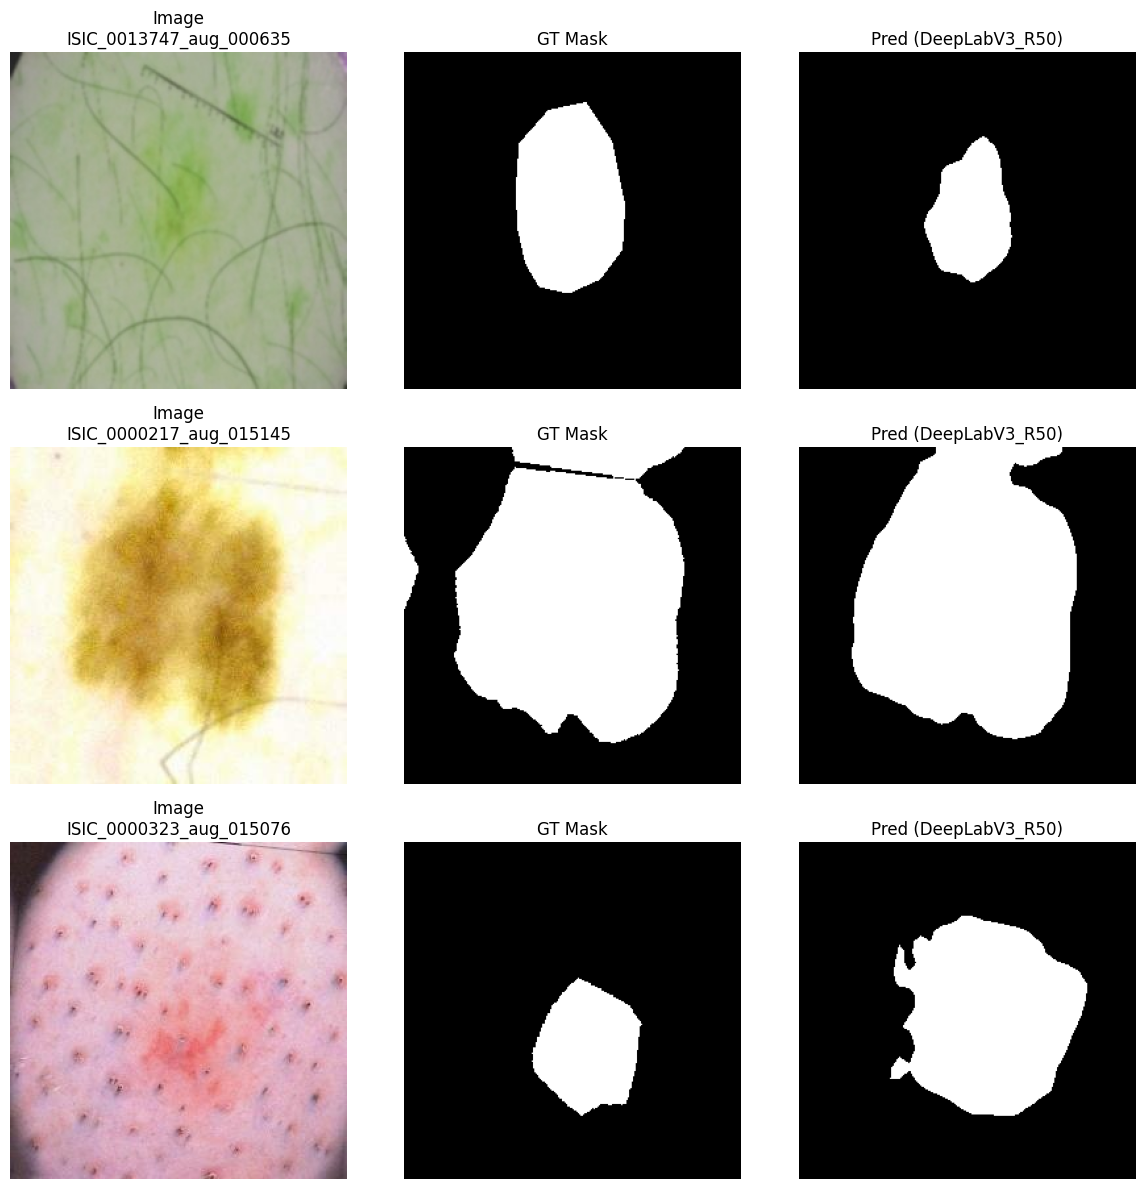

In [24]:

@torch.no_grad()
def visualize_predictions(model, arch_name, ids_pool, n=3):
    model.eval()
    pick = np.random.choice(ids_pool, n, replace=False)

    cols = 3  # image, gt, pred
    plt.figure(figsize=(4*cols, 4*n))

    for i, img_id in enumerate(pick, 1):
        
        img = cv2.imread(os.path.join(IMG_DIR, img_id + IMG_EXT))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gt  = cv2.imread(os.path.join(MASK_DIR, img_id + MASK_EXT), 0)

    
        ds_tmp = ISICSegDataset(IMG_DIR, MASK_DIR, [img_id], transform=val_tfms)
        x, _ = ds_tmp[0]
        x = x.unsqueeze(0).to(DEVICE)

        logits = model_forward(model, x, arch_name)
        prob = torch.sigmoid(logits)[0, 0].cpu().numpy()
        pred = (prob > 0.5).astype(np.uint8) * 255

        r = i - 1
        plt.subplot(n, cols, r*cols + 1)
        plt.imshow(img); plt.axis("off"); plt.title(f"Image\n{img_id}")

        plt.subplot(n, cols, r*cols + 2)
        plt.imshow(gt, cmap="gray"); plt.axis("off"); plt.title("GT Mask")

        plt.subplot(n, cols, r*cols + 3)
        plt.imshow(pred, cmap="gray"); plt.axis("off"); plt.title(f"Pred ({arch_name})")

    plt.tight_layout()
    plt.show()

print("\nShowing prediction visualizations on TEST set...")


visualize_predictions(vgg, "VGG16_UNet", test_ids, n=3)

visualize_predictions(dl, "DeepLabV3_R50", test_ids, n=3)


In [25]:
!zip -r saved_models.zip saved_models
print("Created: saved_models.zip (download it from the right panel)")


  adding: saved_models/ (stored 0%)
  adding: saved_models/DeepLabV3_R50_BEST.pth (deflated 7%)
  adding: saved_models/DeepLabV3_R50_BEST_val0.8879.pth (deflated 7%)
  adding: saved_models/VGG16_UNet_BEST.pth (deflated 7%)
Created: saved_models.zip (download it from the right panel)
